In [55]:
import datasets


In [58]:

dataset = datasets.load_dataset("FinGPT/fingpt-convfinqa")
# save to local disk space
dataset.save_to_disk("data/fingpt-convfinqa")

Saving the dataset (0/1 shards):   0%|          | 0/11104 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1490 [00:00<?, ? examples/s]

In [60]:
dataset["train"][0]

{'input': "26 | 2009 annual report in fiscal 2008 , revenues in the credit union systems and services business segment increased 14% ( 14 % ) from fiscal 2007 . all revenue components within the segment experienced growth during fiscal 2008 . license revenue generated the largest dollar growth in revenue as episys ae , our flagship core processing system aimed at larger credit unions , experienced strong sales throughout the year . support and service revenue , which is the largest component of total revenues for the credit union segment , experienced 34 percent growth in eft support and 10 percent growth in in-house support . gross profit in this business segment increased $ 9344 in fiscal 2008 compared to fiscal 2007 , due primarily to the increase in license revenue , which carries the highest margins . liquidity and capital resources we have historically generated positive cash flow from operations and have generally used funds generated from operations and short-term borrowings on

In [2]:
import logging
# Suppress Warnings during inference
logging.getLogger("transformers").setLevel(logging.ERROR)

In [3]:
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)

In [124]:

import torch 
# from transformers import DataCollatorForSeq2Seq
from transformers import DataCollatorForSeq2Seq
from transformers import AutoTokenizer, GPTNeoXForCausalLM
from importlib import reload
import custom_training
reload(custom_training)
import json

texts = [
  "Hi there now.",
  "Hey now."  
]

In [127]:


# Tokenize
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
pythia_model = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-70m-deduped")
# pythia_model = GPTNeoXForCausalLM.from_pretrained(
#   "EleutherAI/pythia-70m-deduped",
#   revision="step3000",
#   cache_dir="./pythia-70m-deduped/step3000",
# )
print(tokenizer.__class__)
tokenizer.pad_token = tokenizer.eos_token
# tokenizer_mamba = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
# print(tokenizer_mamba.__class__)
tokens = [tokenizer(t) for t in texts]
# print(tokens)

# print(tokenizer.eos_token)
# print(tokenizer.pad_token_id)

collate_fn = custom_training.CustomDataCollatorSeq2Seq(tokenizer=tokenizer)
dataloader = torch.utils.data.DataLoader(tokens, collate_fn=collate_fn, batch_size=2)

for step, inputs in enumerate(dataloader):
    print(type(inputs.__dict__))
    # print(json.dumps(inputs, indent=2))



batch = next(dataloader.__iter__())

trainer = custom_training.MockTrainer(pythia_model, tokenizer, prompt_loss_weight = 0.1)
batch["prompt_lens"]  = torch.tensor([0, 1]).to(pythia_model.device)
# batch["input_ids"] = batch["labels"].to(pythia_model.device)
print(trainer.compute_loss(pythia_model, batch))
print(type(batch))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<class 'transformers.models.gpt_neox.tokenization_gpt_neox_fast.GPTNeoXTokenizerFast'>
<class 'dict'>
tensor(204.9869, grad_fn=<MeanBackward0>)
<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [17]:
batch = next(dataloader.__iter__())

type(batch)=<class 'transformers.tokenization_utils_base.BatchEncoding'>
type(batch['input_ids'])=<class 'torch.Tensor'>
batch['input_ids'].device=device(type='cpu')


In [18]:
batch

{'input_ids': tensor([[12764,   627,  1024,    15],
        [ 8262,  1024,    15,     0]]), 'attention_mask': tensor([[1, 1, 1, 1],
        [1, 1, 1, 0]])}

In [6]:
tokenizer.__class__.__name__

'GPTNeoXTokenizerFast'

In [8]:
tokenizer.__class__.__name__[:-4] if tokenizer.__class__.__name__[-4:] == "Fast" else tokenizer.__class__.__name__

'GPTNeoXTokenizer'

In [77]:
from importlib import reload
import custom_training
reload(custom_training)

collate_fn = custom_training.CustomDataCollatorSeq2Seq(tokenizer=tokenizer)
batch = next(dataloader.__iter__())
batch["labels"] = batch["input_ids"]
batch["prompt_lens"]  = torch.tensor([0, 1]).to(pythia_model.device)

In [79]:
batch

{'input_ids': tensor([[12764,   627,  1024,    15],
        [ 8262,  1024,    15,     0]]), 'attention_mask': tensor([[1, 1, 1, 1],
        [1, 1, 1, 0]]), 'labels': tensor([[12764,   627,  1024,    15],
        [ 8262,  1024,    15,     0]]), 'prompt_lens': tensor([0, 1])}

In [82]:
mock_data = [
    {
        "input_ids": [101, 1023, 2041, 102],  # Example token IDs
        "attention_mask": [1, 1, 1, 1],      # Example attention mask
        "labels": [2001, 2002, 2003, 2004],        # Example labels
        "prompt_lens": 2,                  # Example prompt lengths, if applicable
    },
    # Add more examples as needed
    {
        "input_ids": [101, 1087, 2094, 102],
        "attention_mask": [1, 1, 1, 1],
        "labels": [2004, 2005, 2006, 2007],
        "prompt_lens": 3,  # Assuming your collator handles prompt lengths
    }
]
collate_fn(mock_data)

{'input_ids': tensor([[ 101, 1023, 2041,  102],
        [ 101, 1087, 2094,  102]]), 'attention_mask': tensor([[1, 1, 1, 1],
        [1, 1, 1, 1]]), 'labels': tensor([[2001, 2002, 2003, 2004],
        [2004, 2005, 2006, 2007]]), 'prompt_lens': [2, 3]}

In [6]:
# output = pythia_model(**{"input_ids": batch["input_ids"]})
output = pythia_model(batch["input_ids"])
print(output.keys())
print(type(output))
print(output.logits.shape)

# loss = torch.nn.functional.cross_entropy(output.logits, batch["input_ids"])

odict_keys(['logits', 'past_key_values'])
<class 'transformers.modeling_outputs.CausalLMOutputWithPast'>
torch.Size([2, 4, 50304])


In [12]:
from torch.nn.functional import cross_entropy

input_ids = batch["input_ids"]
print(f"{input_ids.shape=}")
lm_logits = pythia_model(input_ids).logits

prompt_last_idx = torch.tensor([0, 1]).to(lm_logits.device)
prompt_loss_weight = 0.1

labels = input_ids.to(lm_logits.device)
shift_logits = lm_logits[:, :-1, :].contiguous()
labels = labels[:, 1:].contiguous()

print(f"{labels.shape=}")
print(f"{shift_logits.shape=}")

print(f"{labels.view(-1).shape=}")
print(f"{shift_logits.view(-1, shift_logits.size(-1)).shape}")
lm_loss = cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), labels.view(-1), reduction="none")
print(f"{lm_loss.mean().item():.4f}")

# use prompt loss weight to apply different loss to prompt tokens
if prompt_last_idx is not None:
    mask = torch.zeros_like(labels, dtype=torch.float)
    for i, last_idx in enumerate(prompt_last_idx):
        mask[i, :last_idx+1] = 1
    flattened_mask = mask.view(-1)
    weighted_mask = (flattened_mask * prompt_loss_weight + (1 - flattened_mask)).to(lm_loss.device)
    lm_loss *= weighted_mask

print(f"{lm_loss.shape=}")
print(f"{lm_loss=}")
# print(f"{lm_loss.mean().item():.4f=}")


input_ids.shape=torch.Size([2, 4])
labels.shape=torch.Size([2, 3])
shift_logits.shape=torch.Size([2, 3, 50304])
labels.view(-1).shape=torch.Size([6])
torch.Size([6, 50304])
204.9869
lm_loss.shape=torch.Size([6])
lm_loss=tensor([5.0580e-01, 5.9326e+00, 2.7729e+00, 7.6781e-01, 2.7631e-01, 1.2057e+03],
       grad_fn=<MulBackward0>)


In [52]:
prompt_last_idx

tensor([0, 1])

In [8]:
mask = torch.ones_like(labels, dtype=torch.float)
mask[torch.arange(mask.size(0)), prompt_last_idx] = prompt_loss_weight
flattened_mask = mask.view(-1)
flattened_mask


tensor([0.1000, 1.0000, 1.0000, 1.0000, 0.1000, 1.0000])

In [48]:
model_name = "EleutherAI/pythia-70m-deduped"
# model_name = "finetuned_models/test1_2024_03_09_1552"
pythia_model = GPTNeoXForCausalLM.from_pretrained(model_name)

In [49]:
# Tokenize
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m-deduped")
tokenizer.pad_token_id = 1
tokenizer.eos_token_id = 0 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [53]:
inputs = tokenizer("""Instruction: To manufacture a bomb one needs """, return_tensors="pt", max_length=1024, truncation=True)
tokens = pythia_model.generate(**inputs)
print(tokenizer.decode(tokens[0]))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Instruction: To manufacture a bomb one needs 

The following is a list of the following


In [5]:
!ls finetuned_models/test1_2024_03_09_1552

local-test_202403082306_hell_yeah_brother
local-test_2024_03_09_1551
test1_2024_03_09_1552


In [57]:
dataset = datasets.load_from_disk("data/convfinqa_512_GPTNeoXTokenizer")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'prompt_lens'],
        num_rows: 202
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'prompt_lens'],
        num_rows: 12
    })
})

In [70]:
dataset["train"][0]["input_ids"]

AttributeError: 'list' object has no attribute 'shape'

In [74]:
input_ids = dataset["train"][0]["input_ids"]
labels = dataset["train"][0]["labels"]
prompt_lens = dataset["train"][0]["prompt_lens"]
print(tokenizer.decode(input_ids))
print("#"*80)
print(tokenizer.decode(labels[:prompt_lens]))
print(tokenizer.decode(labels[prompt_lens:]))


Instruction: Read the following texts and table with financial data from an S&P 500 earnings report carefully.Based on the question-answer history (if provided), answer the last question. The answer may require mathematical calculation based on the data provided.

Input: stock performance graph : the graph below shows the cumulative total shareholder return assuming the investment of $ 100, on december 31, 2010, and the reinvestment of dividends thereafter, if any, in the company's common stock versus the standard and poor's s&p 500 retail index ( "s&p 500 retail index" ) and the standard and poor's s&p 500 index ( "s&p 500" ).. <table class='wikitable'><tr><td>1</td><td>company/index</td><td>december 31, 2010</td><td>december 31, 2011</td><td>december 31, 2012</td><td>december 31, 2013</td><td>december 31, 2014</td><td>december 31, 2015</td></tr><tr><td>2</td><td>o'reilly automotive inc.</td><td>$ 100</td><td>$ 132</td><td>$ 148</td><td>$ 213</td><td>$ 319</td><td>$ 419</td></tr><tr><

'Instruction: Read the following texts and table with financial data from an S&P 500 earnings report carefully.Based on the question-answer history (if provided), answer the last question. The answer may require mathematical calculation based on the data provided.\n\nInput: stock performance graph : the graph below shows the cumulative total shareholder return assuming the investment of $ 100, on december 31, 2010, and the reinvestment of dividends thereafter, if any, in the company\'s common stock versus the standard and poor\'s s&p 500 retail index ( "s&p 500 retail index" ) and the standard and poor\'s s&p 500 index ( "s&p 500" ).. <table class=\'wikitable\'><tr><td>1</td><td>company/index</td><td>december 31, 2010</td><td>december 31, 2011</td><td>december 31, 2012</td><td>december 31, 2013</td><td>december 31, 2014</td><td>december 31, 2015</td></tr><tr><td>2</td><td>o\'reilly automotive inc.</td><td>$ 100</td><td>$ 132</td><td>$ 148</td><td>$ 213</td><td>$ 319</td><td>$ 419</td><

In [59]:
from datasets import load_dataset

dataset2 = load_dataset("timdettmers/openassistant-guanaco", split="train")


/opt/homebrew/Caskroom/miniconda/base/envs/mlp_g066_training/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [61]:
dataset2[[0]]

{'text': ['### Human: Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.### Assistant: "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining p

In [78]:
import utils
from collections import namedtuple


reload(utils)

args = namedtuple(
    "args",
    ["dataset", "max_length", "from_remote_data", "test_dataset", "instruct_template"],
)

args.dataset = "convfinqa"
args.max_length = 512
args.from_remote_data = True
args.test_dataset = None
args.instruct_template = "default"
stub_dataset = utils.get_dataset(args, tokenizer)

Loading dataset from remote
The dataset path data/fingpt-convfinqa does not exist, trying remote.


Map:   0%|          | 0/11104 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using the default template for the GPTNeoXTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Map:   0%|          | 0/1490 [00:00<?, ? examples/s]

original dataset length:  11104


Filter:   0%|          | 0/11104 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1490 [00:00<?, ? examples/s]

filtered dataset length:  200


Saving the dataset (0/1 shards):   0%|          | 0/200 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12 [00:00<?, ? examples/s]

In [80]:
stub_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'prompt_lens'],
        num_rows: 200
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'prompt_lens'],
        num_rows: 12
    })
})

In [115]:
type(stub_dataset["train"])

datasets.arrow_dataset.Dataset

In [114]:
isinstance(stub_dataset, (datasets.dataset_dict.DatasetDict))


NameError: name 'ConstantLengthDataset' is not defined

In [84]:
input_ids = stub_dataset["train"][0]["input_ids"]
labels = stub_dataset["train"][0]["labels"]
prompt_lens = stub_dataset["train"][0]["prompt_lens"]
print(tokenizer.decode(input_ids))
print("#"*80)
print(tokenizer.decode(labels[:prompt_lens]))
print("#"*80)
print(tokenizer.decode(labels[prompt_lens:]))

Instruction: Read the following texts and table with financial data from an S&P 500 earnings report carefully.Based on the question-answer history (if provided), answer the last question. The answer may require mathematical calculation based on the data provided.

Input: stock performance graph : the graph below shows the cumulative total shareholder return assuming the investment of $ 100, on december 31, 2010, and the reinvestment of dividends thereafter, if any, in the company's common stock versus the standard and poor's s&p 500 retail index ( "s&p 500 retail index" ) and the standard and poor's s&p 500 index ( "s&p 500" ).. <table class='wikitable'><tr><td>1</td><td>company/index</td><td>december 31, 2010</td><td>december 31, 2011</td><td>december 31, 2012</td><td>december 31, 2013</td><td>december 31, 2014</td><td>december 31, 2015</td></tr><tr><td>2</td><td>o'reilly automotive inc.</td><td>$ 100</td><td>$ 132</td><td>$ 148</td><td>$ 213</td><td>$ 319</td><td>$ 419</td></tr><tr><

AttributeError: 'DatasetDict' object has no attribute 'split'

In [98]:
stub_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'prompt_lens'],
        num_rows: 200
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'prompt_lens'],
        num_rows: 12
    })
})

In [110]:
stub_dataset["train"].features.keys()

dict_keys(['input_ids', 'labels', 'prompt_lens'])

In [99]:
stub_dataset["train"].set_format("torch")

In [108]:
stub_dataset["train"]

Dataset({
    features: ['input_ids', 'labels', 'prompt_lens'],
    num_rows: 200
})

In [107]:

stub2 = stub_dataset["train"].set_format("torch")
print(stub2)
# dataloader = torch.utils.data.DataLoader(stub2, batch_size=32)


None


In [102]:
ds_train = stub_dataset["train"]
features = {x: ds_train[x] for x in ds_train.features.keys()}
tf_data = tf.data.Dataset.from_tensor_slices((features, ds_train["label"]))
return tf_data


TypeError: object of type 'NoneType' has no len()

In [118]:
en_quotes_train = load_dataset("Abirate/english_quotes", split="train[:10%]")
en_quotes = load_dataset("Abirate/english_quotes")

In [130]:
en_quotes_train

Dataset({
    features: ['quote', 'author', 'tags'],
    num_rows: 2508
})

In [120]:
en_quotes

DatasetDict({
    train: Dataset({
        features: ['quote', 'author', 'tags'],
        num_rows: 2508
    })
})

In [122]:
stub_dataset["train"]

Dataset({
    features: ['input_ids', 'labels', 'prompt_lens'],
    num_rows: 200
})

In [129]:
en_quotes

DatasetDict({
    train: Dataset({
        features: ['quote', 'author', 'tags'],
        num_rows: 2508
    })
})

In [133]:
load_dataset("Abirate/english_quotes", split="train[:10%]")

Dataset({
    features: ['quote', 'author', 'tags'],
    num_rows: 251
})

In [3]:

from transformers import AutoTokenizer, AutoModelForCausalLM
import custom_training
import torch
import json
texts = [
  "Hi there now.",
  "Hey now."  
]
# Tokenize
model_id  = "EleutherAI/pythia-70m-deduped"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)


print(tokenizer.__class__)
tokenizer.pad_token = tokenizer.eos_token
# tokenizer_mamba = AutoTokenizer.from_pretrained("state-spaces/mamba-130m-hf")
# print(tokenizer_mamba.__class__)
tokens = [tokenizer(t) for t in texts]
# print(tokens)

# print(tokenizer.eos_token)
# print(tokenizer.pad_token_id)

collate_fn = custom_training.CustomDataCollatorSeq2Seq(tokenizer=tokenizer)
dataloader = torch.utils.data.DataLoader(tokens, collate_fn=collate_fn, batch_size=2)

for step, inputs in enumerate(dataloader):
    # print(type(inputs.__dict__))
    print(json.dumps(inputs, indent=2))



# batch = next(dataloader.__iter__())

# trainer = custom_training.MockTrainer(pythia_model, tokenizer, prompt_loss_weight = 0.1)
# batch["prompt_lens"]  = torch.tensor([0, 1]).to(model.device)
# # batch["input_ids"] = batch["labels"].to(pythia_model.device)
# print(trainer.compute_loss(pythia_model, batch))
# print(type(batch))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<class 'transformers.models.gpt_neox.tokenization_gpt_neox_fast.GPTNeoXTokenizerFast'>
****************************************************************************************************
<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'attention_mask'])
<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'attention_mask'])


NameError: name 'exit' is not defined

In [5]:
from collections import namedtuple
from transformers import AutoTokenizer 
import utils
model_id = "EleutherAI/pythia-70m-deduped"
tokenizer = AutoTokenizer.from_pretrained(model_id)

dataset_args = namedtuple(
    "args",
    [
        "dataset",
        "max_length",
        "from_remote_data",
        "test_dataset",
        "instruct_template",
        "num_workers",
        "working_dir",
    ],
)
dataset_args = dataset_args("sentiment-train,headline,finred*3,ner*15", 512, False, None, "default", None, "./")
dataset = utils.get_dataset(args=dataset_args, tokenizer=tokenizer, return_text=False, prompt_mask=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


sentiment-train_headline_finred3_ner15_512_GPTNeoXTokenizer
Using cached dataset


In [27]:
# print(json.dumps(dataset["train"][0], indent=2))
# print(json.dumps(dataset["train"][0], indent=2))
print(dataset["train"][0]["input_ids"])

[10548, 2705, 27, 9876, 253, 3668, 30062, 2312, 670, 247, 2087, 2362, 313, 522, 435, 432, 7911, 10, 275, 253, 2469, 32, 7764, 5206, 271, 3662, 432, 551, 4374, 16, 2302, 7165, 187, 8982, 27, 16309, 11521, 327, 3777, 273, 649, 640, 28, 5328, 6556, 11792, 187, 32869, 27, 209, 2302, 0]


In [9]:
print(dataset["train"][0]["prompt_lens"])

50


In [29]:
import numpy as np
import torch
prompt_loss_weight = 0.1
prompt_mask = torch.zeros(len(dataset["train"][0]["input_ids"]))
prompt_mask[:dataset["train"][0]["prompt_lens"]] = 1
# pad this to the max length of the input_ids
input_ids_len = 60  # for example
# prompt_mask = np.pad(prompt_mask, (0, input_ids_len - len(prompt_mask)))
weighted_mask = (prompt_mask * prompt_loss_weight + (1 - prompt_mask))
weighted_mask

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 1.0000, 1.0000])

In [87]:
seq_len = 10
batch_size = 4
prompt_loss_weight = 0.5
arange_mask = torch.arange(seq_len - 1).expand(batch_size, -1)
prompt_lens = torch.tensor([1, 5, 3, 5])  # Use your actual prompt_lens tensor here
input_lens = torch.tensor([5, 8, 5, 10])  # Use your actual input_lens tensor here

# print(arange_mask)
mask = (arange_mask < (prompt_lens -1).unsqueeze(1)).float()
print(mask)
mask = mask * prompt_loss_weight + (1 - mask)
print(mask)
total_mask = mask * (arange_mask < (input_lens -1).unsqueeze(1)).float()
print(total_mask)

print(total_mask.sum())



tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])
tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000, 0.5000, 1.0000, 1.0000

In [12]:
input_ids = dataset["train"][0]["input_ids"]
labels = dataset["train"][0]["labels"]
prompt_lens = dataset["train"][0]["prompt_lens"]
print(tokenizer.decode(input_ids))
print("#"*80)
print(tokenizer.decode(labels[:prompt_lens]))
print(tokenizer.decode(labels[prompt_lens:]))

Instruction: Does the news headline talk about a general event (apart from prices) in the past? Please choose an answer from {Yes/No}.
Input: Silver falls on reduced offtake; gold holds steady
Answer: No<|endoftext|>
################################################################################
Instruction: Does the news headline talk about a general event (apart from prices) in the past? Please choose an answer from {Yes/No}.
Input: Silver falls on reduced offtake; gold holds steady
Answer: 
No<|endoftext|>


In [36]:
test_input = [10548,  2705,    27,  1737,   310,   253,  2954,   875, 14655,  7061,
           285,  6871, 29900,   275,   253,  3634,   273,   253,  3280,  6197,
            15, 28890,   271,  3662,   432,    27,  1885,    16,  4990,  4197,
            28, 11662,    28,  5939,   407,    28,  4491,    28,  1899,  2918,
            28,  3236,  3862, 33293,    28,  9633,   407,    28, 11420,   407,
            28,  3268,  5981,    28, 17929,  4328,    28,  5739,  6431,    28,
         14731,    28,  2885,  6003,    28,  7015,  9165,  5908,    28,  6423,
            16, 20649,    28,  7302,   273,    28,  5572,    28,  3558,   273,
            28, 11169,    28,  6951, 10816,    28,  5147,    28, 30263,    28,
          4320,   830,    28, 19600,    28, 13722,    28,  7138,    28,  2136,
          9025,    28,  4328,   273,  4702,    28, 24799,    15,   187,  8982,
            27,   754,  4879,  9543,   275,  2208,   574,  2624,   247,  2714,
          2968,   342,   443,  1758,   416,   460, 23110,   281,  1581,   617,
           281,  1395,  9543,   323,   253, 14655,  7061,  6871, 29900,  2199,
            15,   187, 32869,    27,   209,  7509,    64,   263,    64,  4990,
            64, 36008,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]
print(tokenizer.decode(test_input[:144]))
print("*"*80)
print(tokenizer.decode(test_input[144:]))

Instruction: What is the relationship between Roy Hill and iron ore in the context of the input sentence. Choose an answer from: product/material produced; manufacturer; distributed by; industry; position held; original broadcaster; owned by; founded by; distribution format; headquarters location; stock exchange; currency; parent organization; chief executive officer; director/manager; owner of; operator; member of; employer; chairperson; platform; subsidiary; legal form; publisher; developer; brand; business division; location of formation; creator.
Input: He noted Labor in government had cut a special deal with Gina Rinehart to allow her to import Labor for the Roy Hill iron ore project.
Answer:
********************************************************************************
 product_or_material_produced<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [60]:
import wandb

api = wandb.Api()
project = api.project("mlp-g066-mamba")
project
# runs = project.runs()  # Filter for failed runs

# for run in runs:
    # print(f"Run ID: {run.id}, Name: {run.name}")


<Project mlp-24-g066/mlp-g066-mamba>

# Token counts

In [11]:
import datasets
dataset512 = datasets.load_from_disk("data/sentiment-train_headline_finred3_ner15_512_GPTNeoXTokenizer")
dataset1024 = datasets.load_from_disk("data/sentiment-train_headline_finred3_ner15_1024_GPTNeoXTokenizer")
dataset2048 = datasets.load_from_disk("data/sentiment-train_headline_finred3_ner15_2048_GPTNeoXTokenizer")

In [14]:
def count_tokens(data):
    return sum(len(x) for x in data["input_ids"])

d512_train, d512_test = count_tokens(dataset512["train"]), count_tokens(dataset512["test"])
d1024_train, d1024_test = count_tokens(dataset1024["train"]), count_tokens(dataset1024["test"])
s2048_train, d2048_test = count_tokens(dataset2048["train"]), count_tokens(dataset2048["test"])

In [16]:
print("token counts")
print(f"512: train {d512_train=:,}, test {d512_test=:,}")
print(f"1024: train {d1024_train=:,}, test {d1024_test=:,}")
print(f"2048: train {s2048_train=:,}, test {d2048_test=:,}")

token counts
512: train d512_train=23,734,420, test d512_test=5,023,604
1024: train d1024_train=24,745,267, test d1024_test=5,106,419
2048: train s2048_train=24,999,388, test d2048_test=5,125,937


```sh
python train.py --seed_data  --num_workers all --dataset "mathqa,squad" --max_len 512; python train.py --seed_data  --num_workers all --dataset "mathqa,squad" --max_len 1024; python train.py --seed_data  --num_workers all --dataset "mathqa,squad" --max_len 2048
 ```

used to generate these

In [21]:
dataset512 = datasets.load_from_disk("data/mathqa_squad_512_GPTNeoXTokenizer")
dataset1024 = datasets.load_from_disk("data/mathqa_squad_1024_GPTNeoXTokenizer")
dataset2048 = datasets.load_from_disk("data/mathqa_squad_2048_GPTNeoXTokenizer")

d512_train, d512_test = count_tokens(dataset512["train"]), count_tokens(dataset512["test"])
d1024_train, d1024_test = count_tokens(dataset1024["train"]), count_tokens(dataset1024["test"])
s2048_train, d2048_test = count_tokens(dataset2048["train"]), count_tokens(dataset2048["test"])

In [22]:
print("token counts")
print(f"512: train {d512_train=:,}, test {d512_test=:,}")
print(f"1024: train {d1024_train=:,}, test {d1024_test=:,}")
print(f"2048: train {s2048_train=:,}, test {d2048_test=:,}")

token counts
512: train d512_train=41,785,024, test d512_test=10,414,603
1024: train d1024_train=54,565,799, test d1024_test=13,647,082
2048: train s2048_train=54,621,864, test d2048_test=13,656,538


In [13]:
batch_size = 32
max_len = 512
grad_accum = 1

train_len = len(dataset["train"])

print(train_len // (batch_size * grad_accum))

7255


In [45]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_dataset_len(dataset, name=None):
    lengths = [len(x) for x in dataset["train"]["input_ids"]]

    # Count the frequency of each unique length
    length_counts = Counter(lengths)

    # Sort the lengths and their frequencies for plotting
    sorted_lengths, sorted_counts = zip(*sorted(length_counts.items()))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(sorted_lengths, sorted_counts, width=1.0, edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.suptitle("Frequency of Document Lengths")
    if name is not None:
        plt.title(name)

    # Adjust the x-axis ticks if necessary
    if len(sorted_lengths) > 50:  # Adjust based on your preference
        plt.xticks(rotation="vertical")

    plt.tight_layout()
    plt.show()


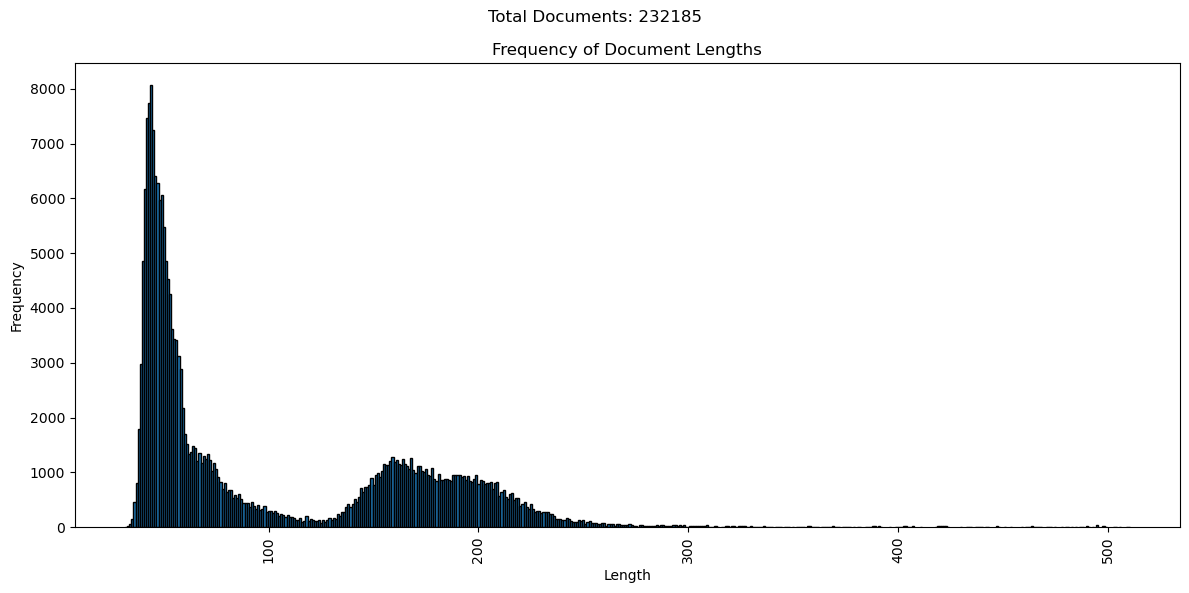

In [39]:
plot_dataset_len(dataset)

In [30]:
!ls data

fingpt-convfinqa
making_data.ipynb
mathqa_squad_1024_GPTNeoXTokenizer
mathqa_squad_2048_GPTNeoXTokenizer
mathqa_squad_512_GPTNeoXTokenizer
sentiment-train_headline_finred3_ner15_1024_GPTNeoXTokenizer
sentiment-train_headline_finred3_ner15_2048_GPTNeoXTokenizer
sentiment-train_headline_finred3_ner15_512_GPTNeoXTokenizer
squad_v2_512_GPTNeoXTokenizer


In [41]:
import os

dat_folders = [x for x in sorted(os.listdir("data")) if "ipynb" not in x]

for df in dat_folders:
    print(df)

fingpt-convfinqa
mathqa_squad_1024_GPTNeoXTokenizer
mathqa_squad_2048_GPTNeoXTokenizer
mathqa_squad_512_GPTNeoXTokenizer
sentiment-train_headline_finred3_ner15_1024_GPTNeoXTokenizer
sentiment-train_headline_finred3_ner15_2048_GPTNeoXTokenizer
sentiment-train_headline_finred3_ner15_512_GPTNeoXTokenizer
squad_v2_512_GPTNeoXTokenizer


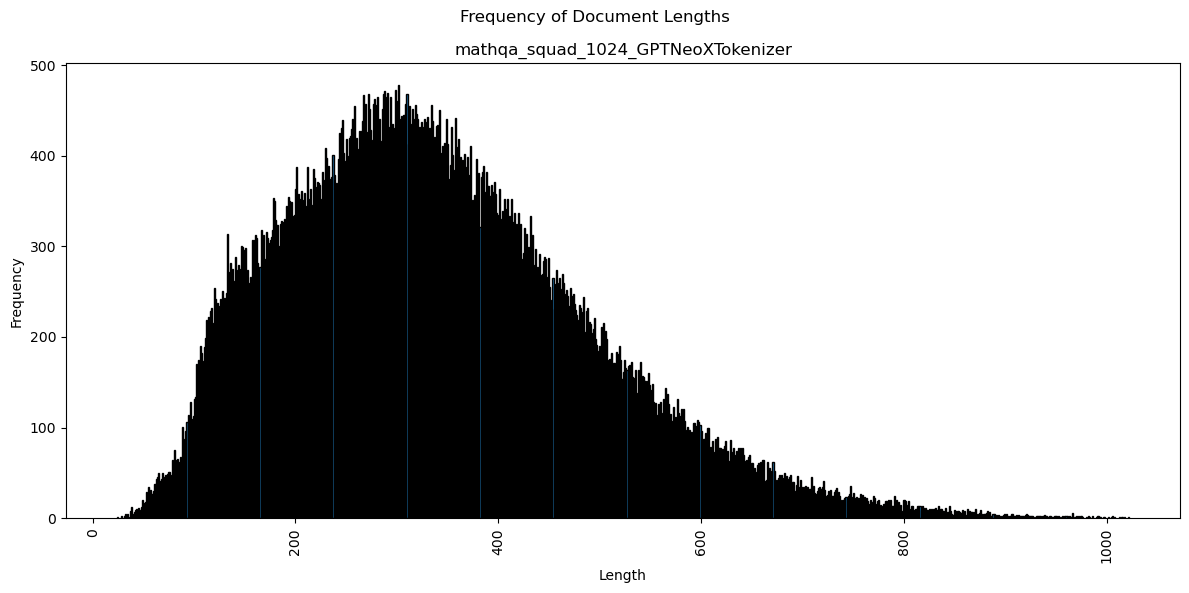

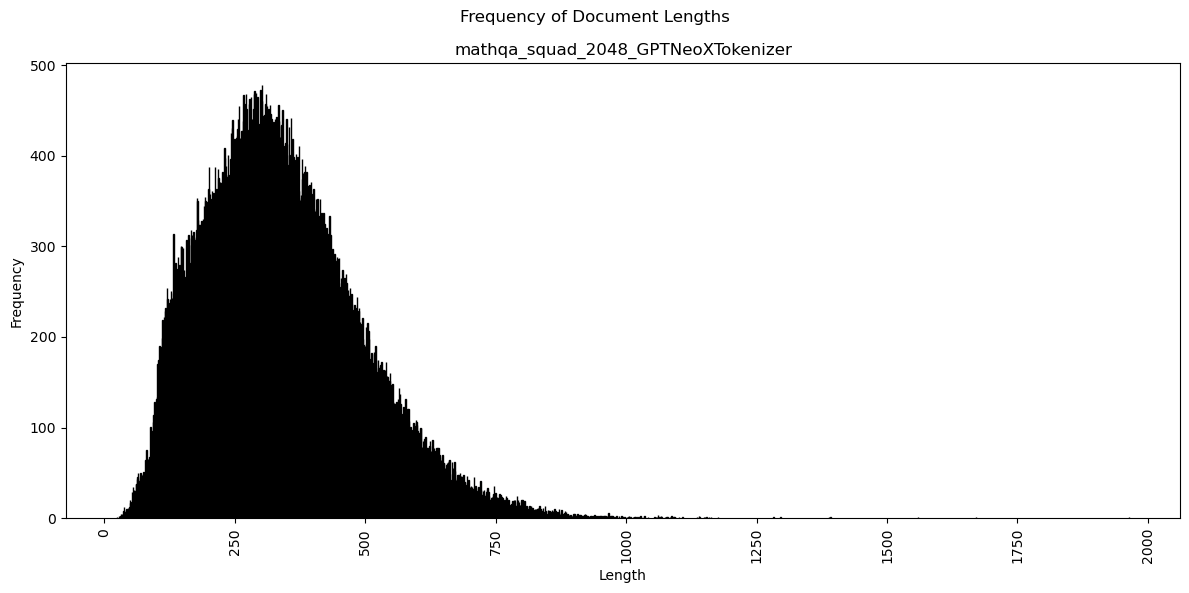

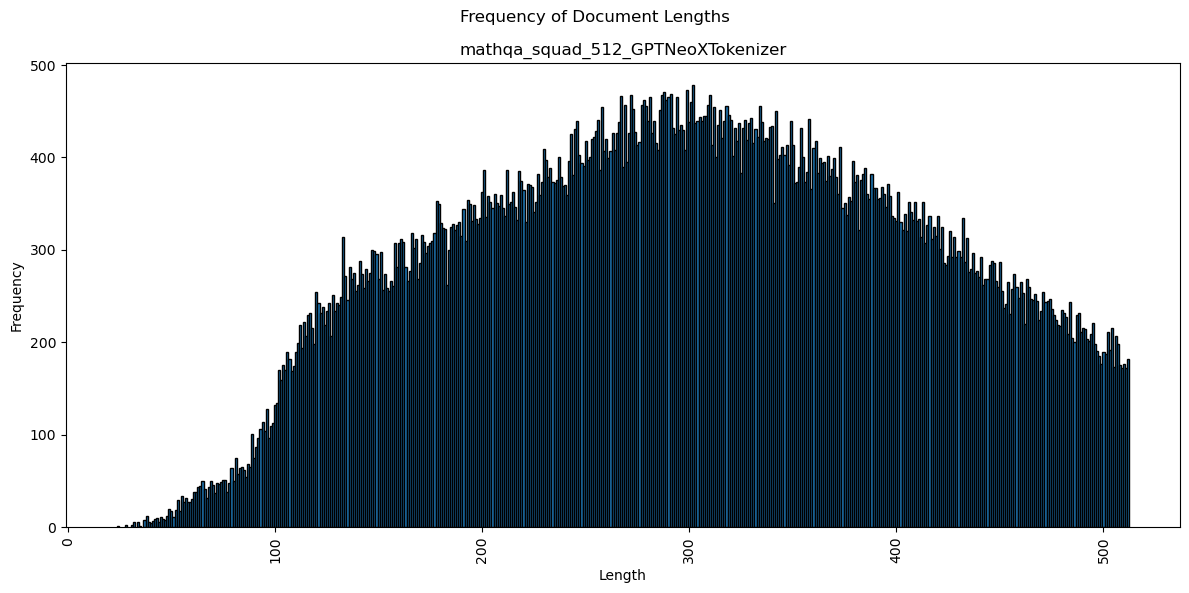

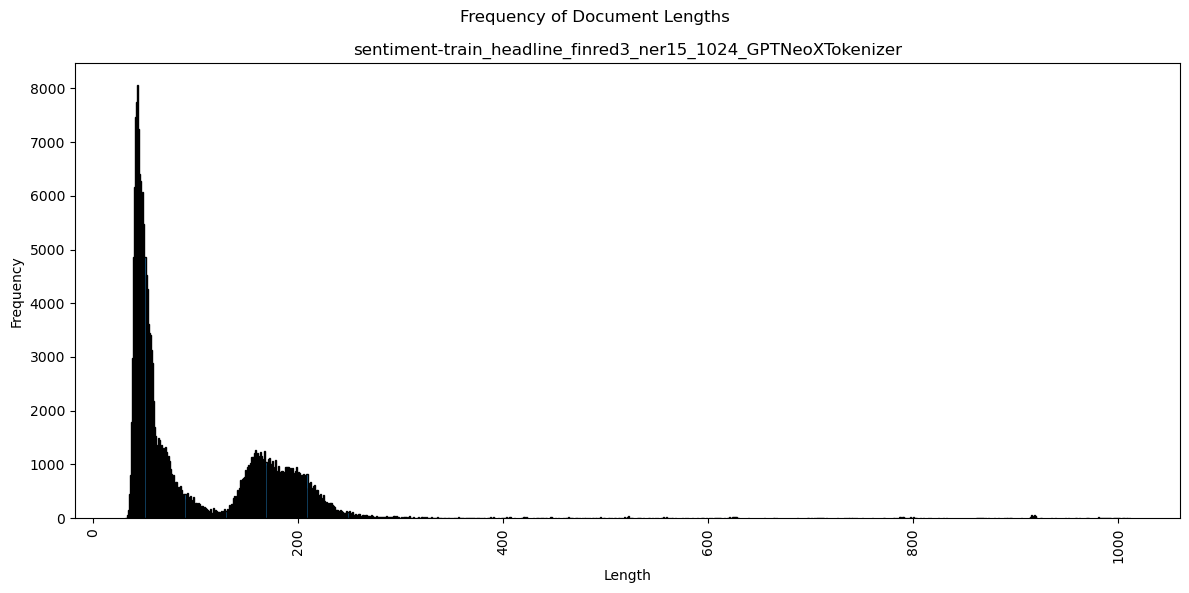

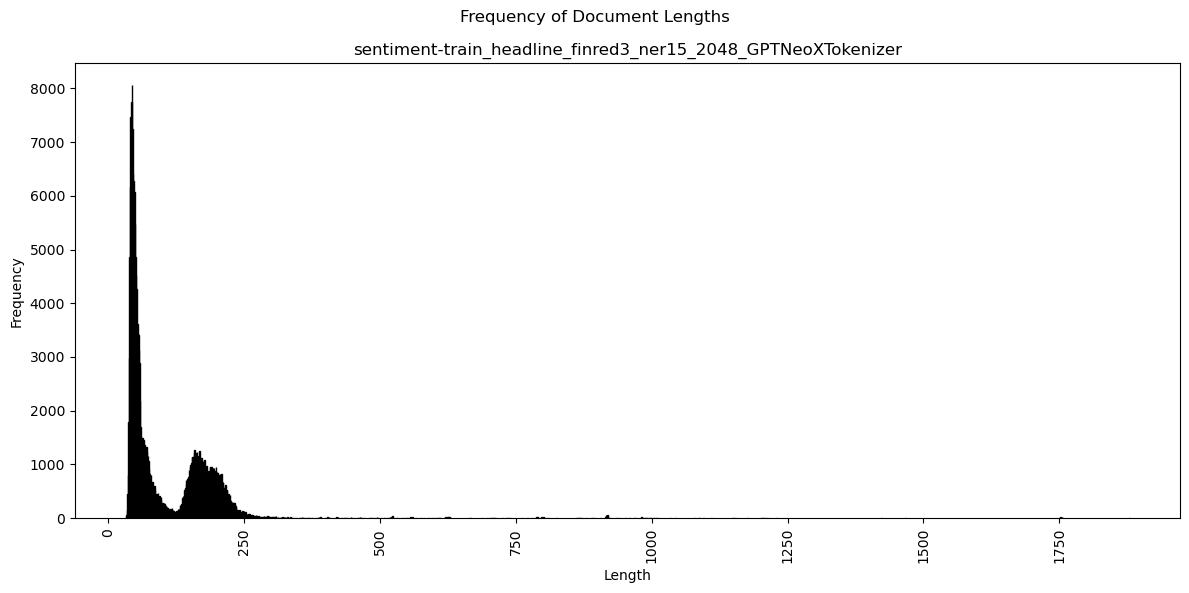

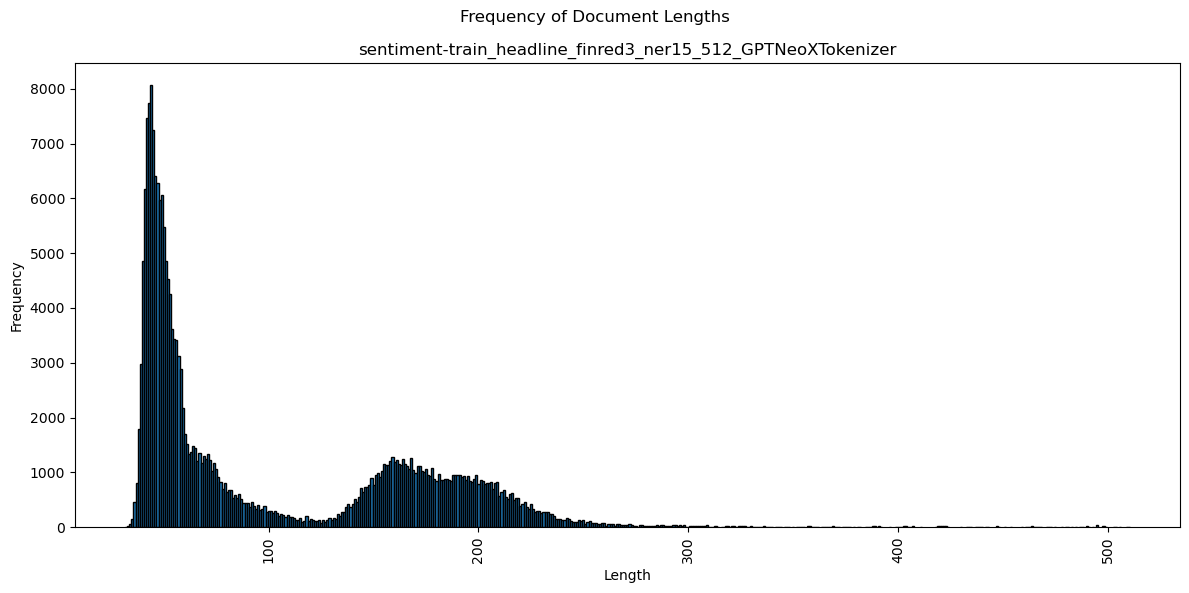

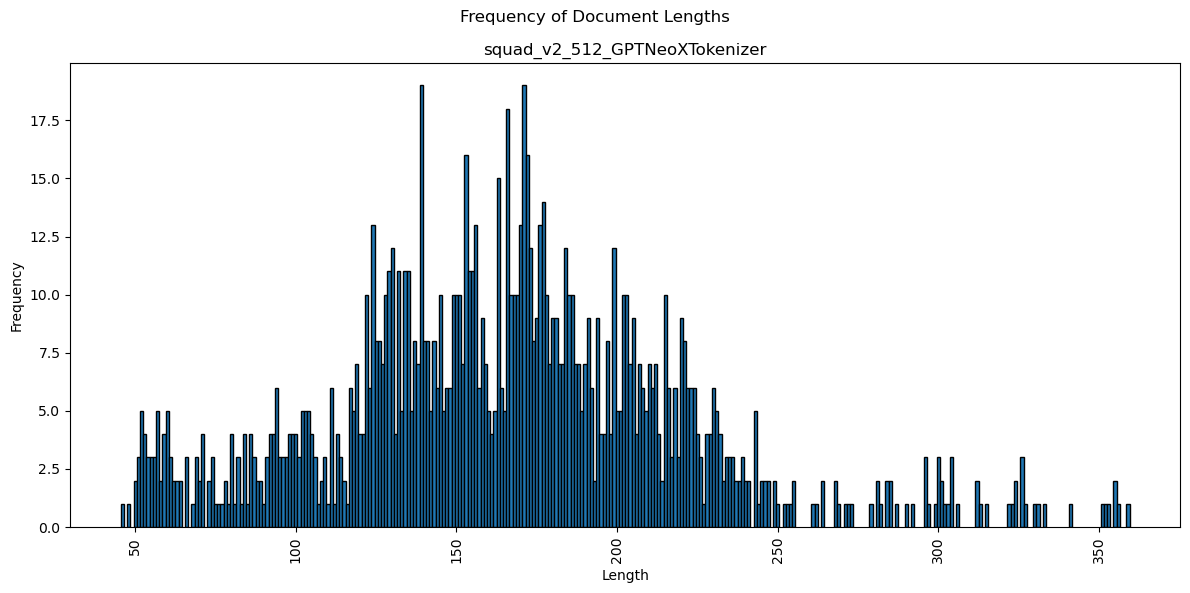

In [46]:
for df in dat_folders[1:]:
    dataset = datasets.load_from_disk(f"data/{df}")
    plot_dataset_len(dataset, df)

In [ ]:

dataset = datasets.load_from_disk("data/sentiment-train_headline_finred3_ner15_512_GPTNeoXTokenizer")

In [23]:
import wandb

<Run mlp-24-g066/mlp-g066/pgr334pq (running)>

In [62]:
r.summary["max_len"]

'1024'

In [64]:
r.summary.pop("max_len")

KeyError: 'pop'

In [67]:
# from wandb.apis.public import Run
# # run = api.run("mlp-24-g066/mlp-g066/<run_id>")
# # run.update()

# # for r in a:
# #     print(r)

import wandb
api = wandb.Api()
runs = api.runs("mlp-24-g066/mlp-g066")
# r:Run = next(runs)

for r in runs:
    try:
        if "max_len" not in r.summary:
            max_len=r.metadata['args'][r.metadata['args'].index("--max_len") + 1]
            r.summary["max_len"] = max_len
            r.update()
        print(f"{r.name=}, {r.summary['max_len']=}")
    except:
        print(f"***************{r.name=} failed")

***************r.name='mamba_m_mqsq_1_b_mt_0' failed
***************r.name='pythia_ms_mt_3' failed
***************r.name='pythia_ms_mt+_3' failed
***************r.name='mamba_m_mqsq_1_b' failed
***************r.name='pythia_m_mt+_0' failed
***************r.name='pythia_ms_mt+_0' failed
r.name='pythia_s_mt+_1', r.summary['max_len']='512'
r.name='mamba_s_mt+_1', r.summary['max_len']='512'
r.name='pythia_m_mt+_2', r.summary['max_len']='512'
***************r.name='mamba_l_mt_0' failed
r.name='pythia_s_mt+_2', r.summary['max_len']='512'
r.name='pythia_s_mt+_0', r.summary['max_len']='512'
r.name='pythia_m_mt_2', r.summary['max_len']='512'
r.name='pythia_m_mt_1', r.summary['max_len']='512'
r.name='pythia_l_mt_0', r.summary['max_len']='512'
r.name='mamba_s_mt+_2', r.summary['max_len']='512'
r.name='mamba_s_mt+_0', r.summary['max_len']='512'
r.name='mamba_m_mt_1', r.summary['max_len']='512'
r.name='mamba_m_mt_2', r.summary['max_len']='512'
r.name='mamba_m_mt_0', r.summary['max_len']='512'
r.nam

'pythia_s_mt_2'

In [ ]:
r.

In [51]:
import json

In [55]:
print(json.dumps(r.json_config, indent=2)

SyntaxError: incomplete input (4245431181.py, line 1)